In [1]:
import kagglehub
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Final Dataset source from: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset?select=phishing_email.csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/ECE 597 Capstone/phishing_email.csv')

In [4]:
data.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [5]:
data['text'] = data['text_combined']
data = data.drop(columns=['text_combined'])
data['text'] = data['text'].str.lower()

# Clean URLs special characters
def clean_text(text):
    text = re.sub(r'\S+@\S+', ' ', text)  # remove email addresses
    text = re.sub(r'http\S+|www\S+', ' ', text)  # remove URLs
    text = re.sub(r'\d+', ' ', text)  # remove numbers
    text = re.sub(r'[^\w\s]', ' ', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    text = re.sub(r'subject', '', text).strip()# remove subject
    return text

data['text'] = data['text'].apply(clean_text)

# Stop words + Lemmatization = Tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['text'] = data['text'].apply(tokenize_and_lemmatize)

In [6]:
data.head()

,label,text
0,0,hpl nom may see attached file hplno xl hplno xl
1,0,nom actual vols th forwarded sabrae zajac hou ...
2,0,enron actuals march april estimated actuals ma...
3,0,hpl nom may see attached file hplno xl hplno xl
4,0,hpl nom june see attached file hplno xl hplno xl


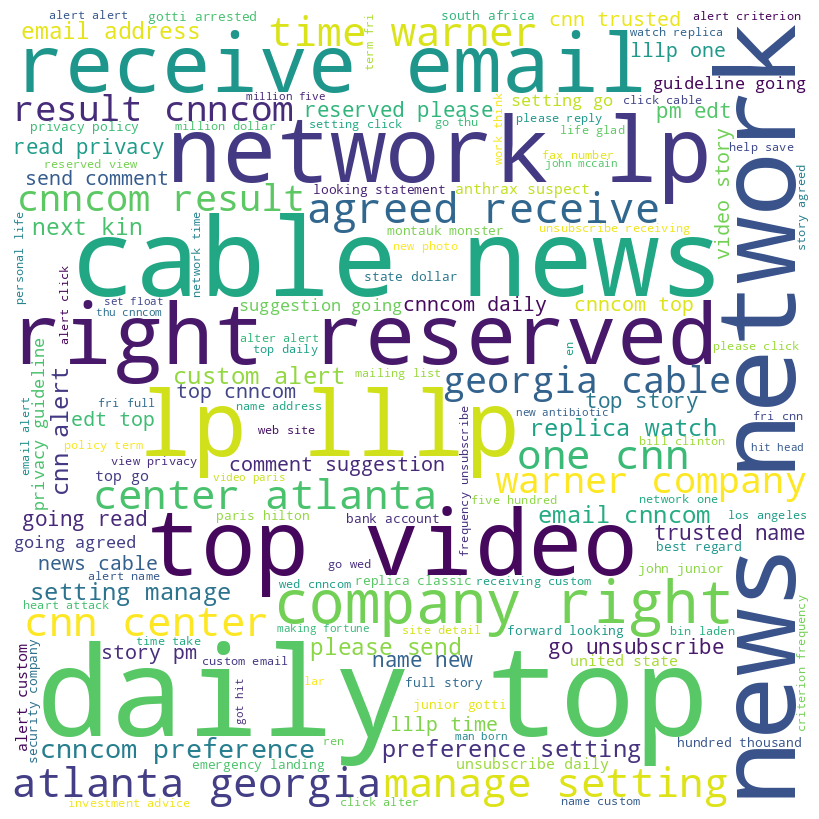

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter out the spam emails
spam_text = data[data['label'] == 1]['text']

# Combine all spam text into a single string
all_spam_text = ' '.join(spam_text)

# Remove meaningless words or symbols (length=1)
filtered_spam_words = [word for word in all_spam_text.split() if len(word) > 1 and word != 'aug']

# Join the filtered words back into a single string
filtered_spam_text = ' '.join(filtered_spam_words)

# Generate the word cloud
wordcloud_spam = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(filtered_spam_text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_spam)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

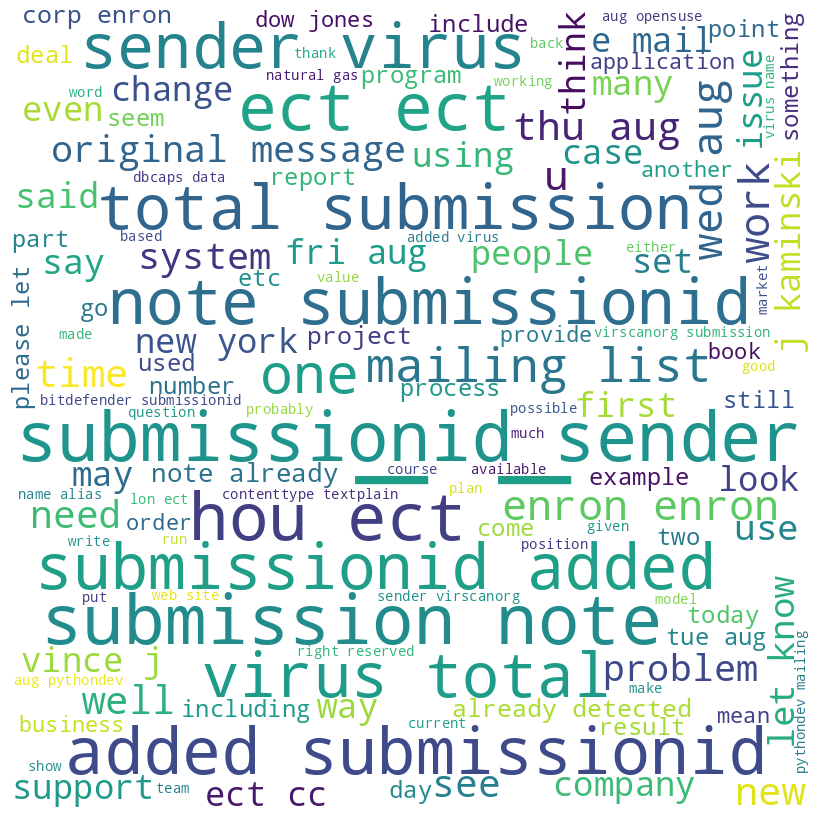

In [8]:
# Filter out the ham emails
ham_text = data[data['label'] == 0]['text']

# Combine all ham text into a single string
all_ham_text = ' '.join(ham_text)

# Remove meaningless words or symbols (length=1)
filtered_ham_words = [word for word in all_ham_text.split() if len(word) > 1 and word != 'aug']

# Join the filtered words back into a single string
filtered_ham_text = ' '.join(filtered_ham_words)

# Generate the word cloud
wordcloud_ham = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_ham_text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_ham)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

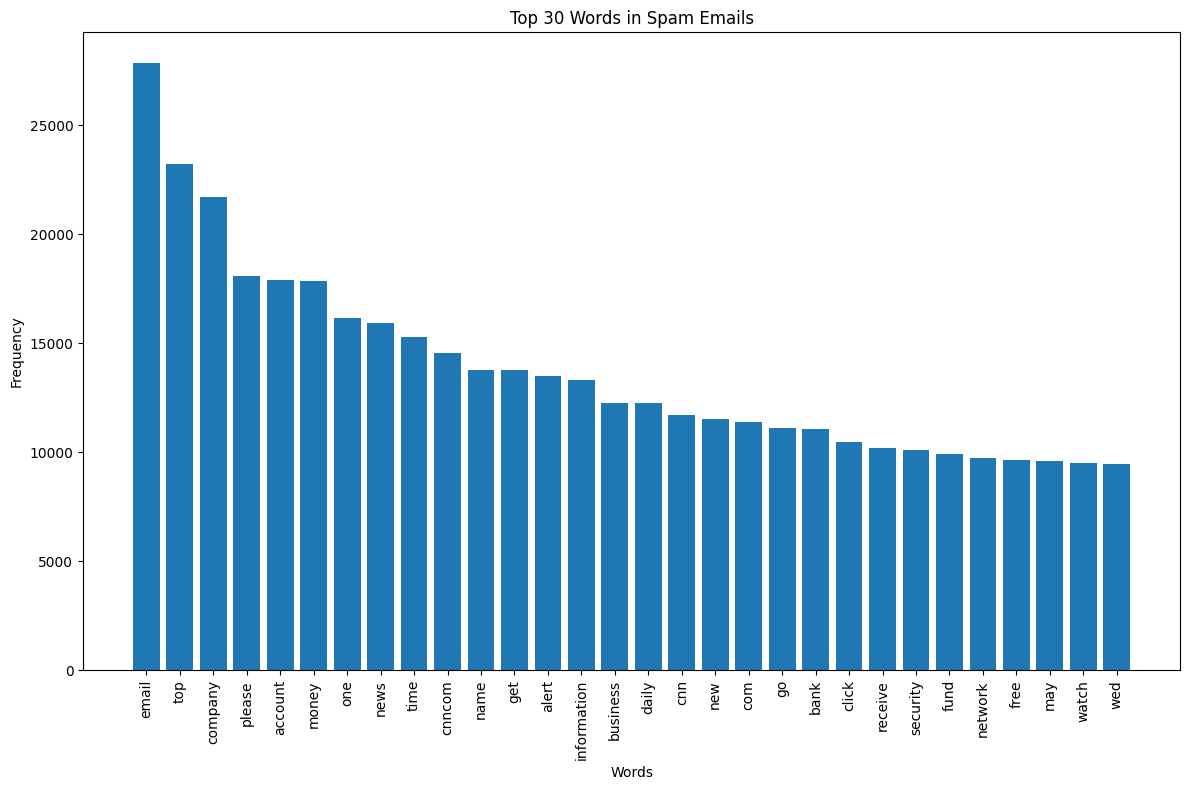

In [9]:
from collections import Counter

# Count the frequency of each word
word_counts = Counter(filtered_spam_words)

# Get the top 30 most common words
top_words = word_counts.most_common(30)

# Separate words and their counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Spam Emails')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

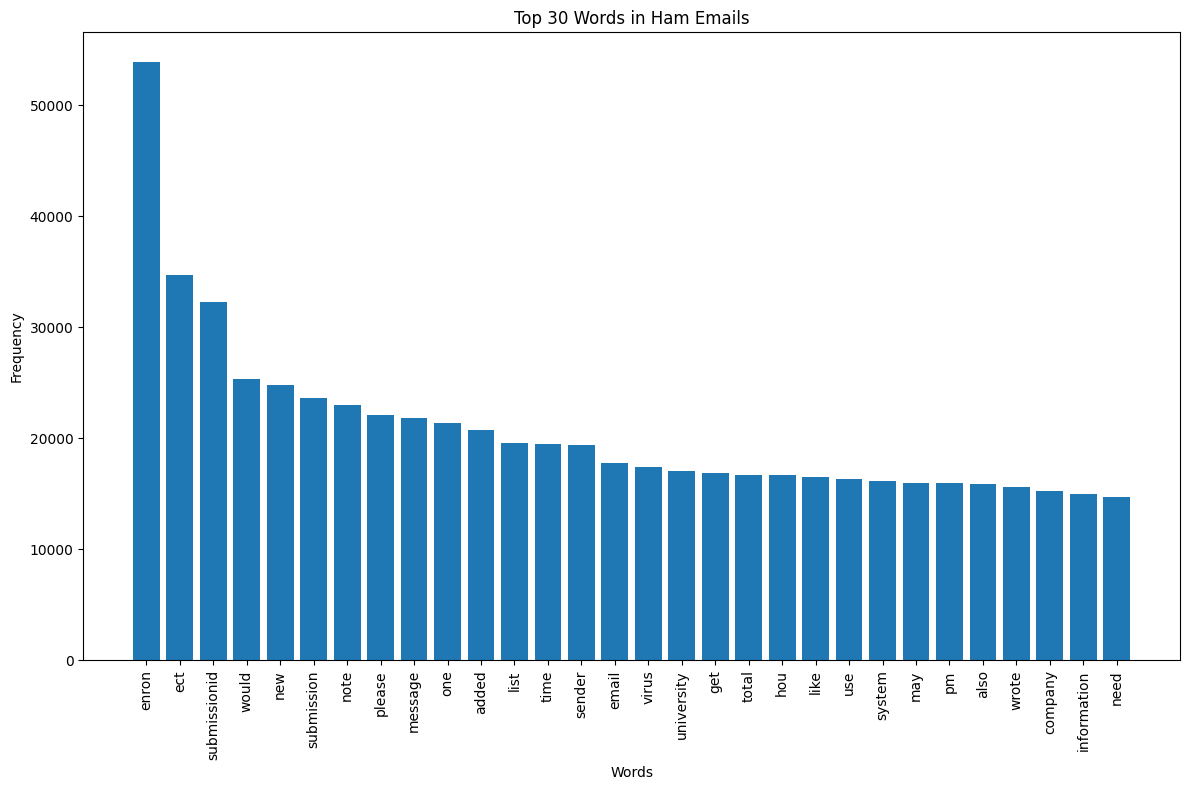

In [10]:
# Count the frequency of each word
word_counts = Counter(filtered_ham_words)

# Get the top 30 most common words
top_words = word_counts.most_common(30)

# Separate words and their counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Ham Emails')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Using 10% of the data as a final test set and applying k-fold validation on the remaining 90%

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# Split data into 90% for cross-validation and 10% for final test set
X = data['text']
y = data['label']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Apply k-fold validation on the remaining 90%
n_splits = 5  # You can adjust the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Print the sizes of the splits for demonstration
print("K-Fold Split Sizes:")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    print(f"Fold {fold+1}:")
    print(f"  Training set size: {len(X_train)}")
    print(f"  Validation set size: {len(X_val)}")

# The final test set (X_test, y_test) is held out until the end for final evaluation
print("\nFinal test set size:")
print(f"  Test set size: {len(X_test)}")

K-Fold Split Sizes:
Fold 1:
  Training set size: 59389
  Validation set size: 14848
Fold 2:
  Training set size: 59389
  Validation set size: 14848
Fold 3:
  Training set size: 59390
  Validation set size: 14847
Fold 4:
  Training set size: 59390
  Validation set size: 14847
Fold 5:
  Training set size: 59390
  Validation set size: 14847

Final test set size:
  Test set size: 8249


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) # You can adjust max_features
X_train_full_vectorized = vectorizer.fit_transform(X_train_full)

# Prepare list to store evaluation results for each fold
fold_accuracies = []

print("\nTraining and evaluating Decision Tree model with K-Fold Cross-Validation:")
# Train and evaluate the Decision Tree model using k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full_vectorized)):
    X_train_fold, X_val_fold = X_train_full_vectorized[train_index], X_train_full_vectorized[val_index]
    y_train_fold, y_val_fold = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Initialize and train the Decision Tree Classifier
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    y_val_pred = dt_model.predict(X_val_fold)

    # Evaluate the model on the validation set
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold+1} Validation Accuracy: {accuracy:.4f}")

# Calculate the average accuracy across all folds
average_validation_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Validation Accuracy across {n_splits} folds: {average_validation_accuracy:.4f}")

# Now, train the model on the entire training dataset (X_train_full) and evaluate on the held-out test set (X_test)
X_test_vectorized = vectorizer.transform(X_test) # Use the same vectorizer fitted on training data

# Train the final model on the full training data
final_dt_model = DecisionTreeClassifier(random_state=42)
final_dt_model.fit(X_train_full_vectorized, y_train_full)

# Evaluate the final model on the test set
y_test_pred = final_dt_model.predict(X_test_vectorized)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")



Training and evaluating Decision Tree model with K-Fold Cross-Validation:
Fold 1 Validation Accuracy: 0.9550
Fold 2 Validation Accuracy: 0.9549
Fold 3 Validation Accuracy: 0.9582
Fold 4 Validation Accuracy: 0.9554
Fold 5 Validation Accuracy: 0.9547

Average Validation Accuracy across 5 folds: 0.9556

Final Test Set Accuracy: 0.9577


Final Test Set Precision: 0.9548
Final Test Set Recall: 0.9643


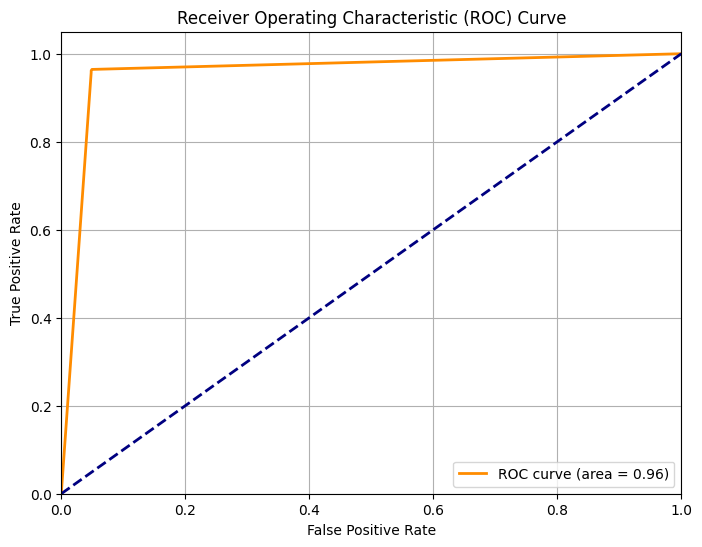

In [13]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate Precision and Recall on the final test set
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"Final Test Set Precision: {precision:.4f}")
print(f"Final Test Set Recall: {recall:.4f}")

# Draw ROC curve
# Get predicted probabilities for the positive class (label 1)
y_test_prob = final_dt_model.predict_proba(X_test_vectorized)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix

# Check confusion matrix before plotting
cm = confusion_matrix(y_test, y_test_pred)

print(cm)

[[3764  196]
 [ 153 4136]]


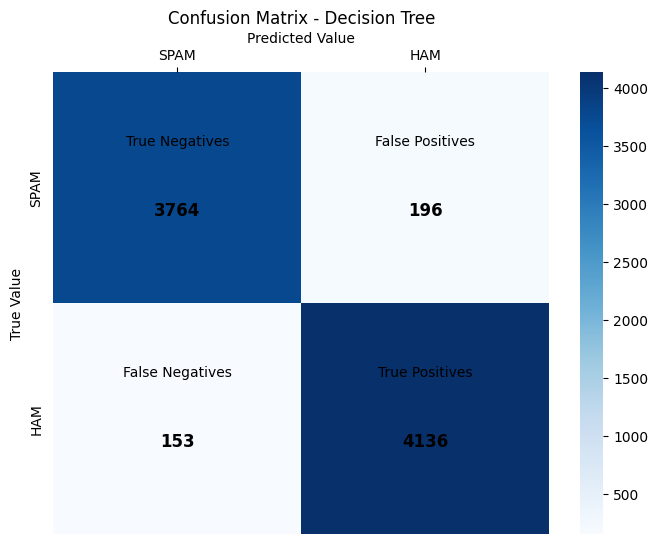

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8, 6)) # Create figure and axes
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=['SPAM', 'HAM'], yticklabels=['SPAM', 'HAM'], ax=ax) # Pass ax to heatmap

# Add custom annotations
labels = np.array([['True Negatives', 'False Positives'],
                   ['False Negatives', 'True Positives']])

# Get the center positions for the annotations
# The positions are slightly adjusted to be above the numbers
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.3, labels[i, j],
                 ha="center", va="center", color="black", fontsize=10)
        plt.text(j + 0.5, i + 0.6, cm[i, j],
                 ha="center", va="center", color="black", fontsize=12, fontweight='bold')

plt.xlabel('Predicted Value')
plt.ylabel('True Value') # Keep ylabel for clarity below the matrix
plt.title('Confusion Matrix - Decision Tree') # Update title

# Move yticklabels to the right and position xlabel at the top
ax.tick_params(left=False, labelleft=True, right=False, labelright=False,
               top=True, labeltop=True, bottom=False, labelbottom=False)

ax.xaxis.set_label_position('top') # Move xlabel to the top
ax.yaxis.set_label_position('left') # Ensure ylabel remains on the left (default)

plt.show()

In [20]:
testData=pd.read_csv('/content/drive/MyDrive/ECE 597 Capstone/Mixed_Formatted_uvic&kaggle_data.csv')

In [ ]:
# Prepare the testData
# Combine 'Subject' and 'Body' columns to create the text for analysis
testData['text'] = testData['Subject'].fillna('') + ' ' + testData['Body'].fillna('')
testData = testData.drop(columns=['Subject', 'Body']) # Drop the original columns
testData['text'] = testData['text'].str.lower()

# Clean URLs special characters
# Use the clean_text function defined earlier
testData['text'] = testData['text'].apply(clean_text)

# Stop words + Lemmatization = Tokenize
# Use the tokenize_and_lemmatize function defined earlier
testData['text'] = testData['text'].apply(tokenize_and_lemmatize)

# Vectorize the test data using the same vectorizer fitted on the training data
X_testData_vectorized = vectorizer.transform(testData['text'])

# Make predictions on the new testData using the trained final_dt_model
testData_predictions = final_dt_model.predict(X_testData_vectorized)

# Add the predictions as a new column to the testData DataFrame
testData['predicted_label'] = testData_predictions

# Print the testData with predictions
print("\nPredictions on the new test data:")
print(testData.head())

In [22]:
testData['label'] = testData['label'].map({'ham': 0, 'spam': 1})

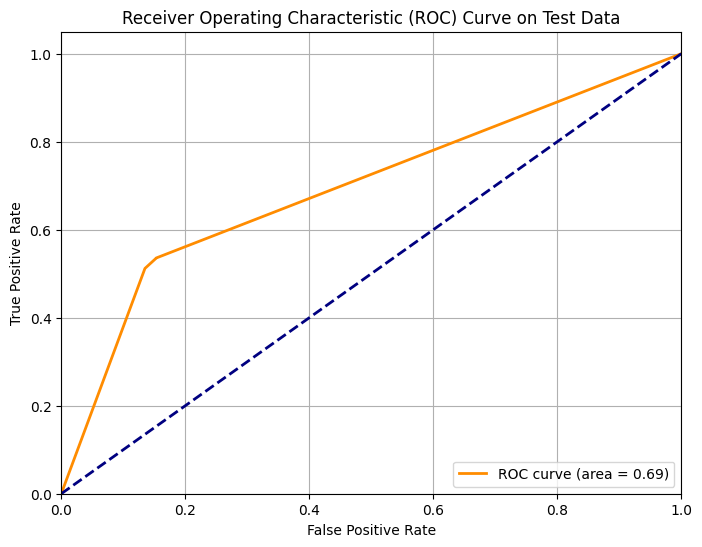

In [26]:
# Get predicted probabilities for the positive class (label 1) on testData
testData_prob = final_dt_model.predict_proba(X_testData_vectorized)[:, 1]

# Calculate ROC curve points for testData
fpr_testData, tpr_testData, thresholds_testData = roc_curve(testData['label'], testData_prob)

# Calculate AUC (Area Under the Curve) for testData
roc_auc_testData = auc(fpr_testData, tpr_testData)

# Plot the ROC curve for testData
plt.figure(figsize=(8, 6))
plt.plot(fpr_testData, tpr_testData, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_testData:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Accuracy on new test data: 0.8454
Precision on new test data: 0.0171
Recall on new test data: 0.5357


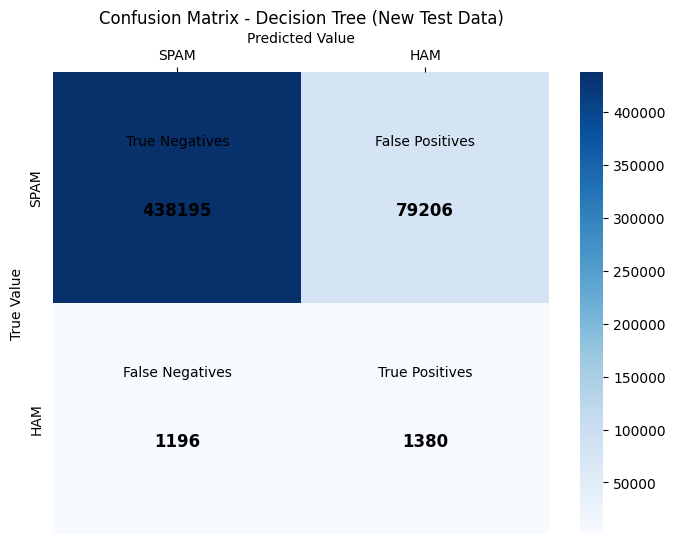

In [23]:
# Calculate accuracy, precision, recall.
if 'label' in testData.columns:
    testData_true_labels = testData['label']
    testData_accuracy = accuracy_score(testData_true_labels, testData_predictions)
    testData_precision = precision_score(testData_true_labels, testData_predictions)
    testData_recall = recall_score(testData_true_labels, testData_predictions)

    print(f"\nAccuracy on new test data: {testData_accuracy:.4f}")
    print(f"Precision on new test data: {testData_precision:.4f}")
    print(f"Recall on new test data: {testData_recall:.4f}")

    # You can also plot the confusion matrix for this new test data if labels are available
    cm_testData = confusion_matrix(testData_true_labels, testData_predictions)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_testData, annot=False, fmt='d', cmap='Blues', xticklabels=['SPAM', 'HAM'], yticklabels=['SPAM', 'HAM'], ax=ax)

    labels_testData = np.array([['True Negatives', 'False Positives'],
                               ['False Negatives', 'True Positives']])

    for i in range(cm_testData.shape[0]):
        for j in range(cm_testData.shape[1]):
            plt.text(j + 0.5, i + 0.3, labels_testData[i, j],
                     ha="center", va="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.6, cm_testData[i, j],
                     ha="center", va="center", color="black", fontsize=12, fontweight='bold')

    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.title('Confusion Matrix - Decision Tree (New Test Data)')

    ax.tick_params(left=False, labelleft=True, right=False, labelright=False,
                   top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')

    plt.show()

# Accuracy = (TP + TF) / (Total Number) Out of entire dataset, percentage of Correctly Predicted Values
# Precision = TP / (TP + FP) Out of all True Predictions, percentage of actuall True
# Recall = TP / (TP + FN) Out of all Actual True values, percentage of True Prediction